In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def get_cuda_autotune_config():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        # Good config for fp8 inputs.
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4)
    ]

@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
        ACTIVATION: tl.constexpr  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # -----------------------------------------------------------
    # Add some integer bound assumptions.
    # This helps to guide integer analysis in the backend to optimize
    # load/store offset address calculation
    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16 #tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `matmul_kernel`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)


# %%
# We can now create a convenience wrapper function that only takes two input tensors,
# and (1) checks any shape constraint; (2) allocates the output; (3) launches the above kernel.


def matmul(a, b, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        ACTIVATION=activation  #
    )
    return c

In [3]:
@triton.jit
def to_int4(v):
    sign = (v & 0x8) != 0
    mag  = (v & 0x7).to(tl.int8)
    return tl.where(sign, -mag, mag)


def get_cuda_autotune_config():
    return [
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=1, num_warps=1),
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=1, num_warps=2),
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=1, num_warps=4),
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=1, num_warps=8),

        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=2, num_warps=1),
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=2, num_warps=2),
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=2, num_warps=4),
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=2, num_warps=8),

        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=3, num_warps=1),
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=3, num_warps=2),
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=3, num_warps=4),
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=3, num_warps=8),

        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=4, num_warps=1),
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=4, num_warps=2),
        # triton.Config({"GROUP_SIZE_M" : 8}, num_stages=4, num_warps=4),
        triton.Config({"GROUP_SIZE_M" : 1}, num_stages=4, num_warps=8),
        ]

@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=[],
)
@triton.jit
def matmul_trellis_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,  #
        # Matrix dimensions
        B, IN, OUT,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # pid = tl.program_id(axis=0)
    # grid_n = tl.cdiv(OUT, 16)
    # pid_m = pid // grid_n
    # pid_n = pid % grid_n


    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(B, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(OUT, 16)
    
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # -----------------------------------------------------------
    # Add some integer bound assumptions.
    # This helps to guide integer analysis in the backend to optimize
    # load/store offset address calculation
    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % B
    offs_ak = tl.arange(0, 16)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_ak[None, :] * stride_ak)
    
    offs_low = (pid_n * 64 + tl.arange(0, 64)) % (OUT * 4)
    offs_high = 1 + tl.arange(0, 64)
    offs_high = (pid_n * 64 + tl.where(offs_high==64, 0, offs_high)) % (OUT * 4)

    b_ptrs_low = b_ptr + offs_low
    b_ptrs_high = b_ptr + offs_high
        
    accumulator_dtype = tl.float32 #tl.float16 #tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, 16), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(IN, 16)):
        a = tl.load(a_ptrs, mask=offs_ak[None, :] < IN - k * 16, other=0.0)
        bits_low = tl.load(b_ptrs_low)#, mask=offs_k[:, None] < IN - k * 16, other=0.0)
        bits_high = tl.load(b_ptrs_high)
        codes = bits_low.to(tl.uint16) | (bits_high.to(tl.uint16) << 8)
        codes = ((codes.to(tl.uint32) * 34038481) >> 9).to(tl.uint16)

        val0 = (codes >> 12) & 0xF
        val1 = (codes >> 8) & 0xF
        val2 = (codes >> 4) & 0xF
        val3 = codes & 0xF

        w0 = to_int4(val0)
        w1 = to_int4(val1)
        w2 = to_int4(val2)
        w3 = to_int4(val3)

        # print("w0", w0)
        # print("w1", w1)
        # print("w2", w2)
        # print("w3", w3)

        w01 = tl.join(w0, w2)
        w23 = tl.join(w1, w3)
        w = tl.join(w01, w23)

        #print(w.shape)

        # w01 = tl.cat(w0, w1, can_reorder=True)
        # w23 = tl.cat(w2, w3, can_reorder=True)
        # w = tl.cat(w01, w23, can_reorder=True)
        
        #w = tl.reshape(w, 4, 64)
        #w = tl.trans(w, 1, 0)
        #print()
        w = tl.reshape(w, 16, 16)
        #print(w)
        #raise
        # We accumulate along the K dimension.
        # print(w)
        accumulator = tl.dot(a, w.to(tl.float16), accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += 16 * stride_ak
        b_ptrs_high += 1 * stride_bk
        b_ptrs_low += 1 * stride_bk


    c = accumulator.to(tl.float16)
    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * 16 + tl.arange(0, 16)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < B) & (offs_cn[None, :] < OUT)
    tl.store(c_ptrs, c, mask=c_mask)


def trellis_matmul_triton(a, b_compressed):
    b_compressed = b_compressed.reshape(b_compressed.shape[0], -1)
    
    assert a.shape[1] == b_compressed.shape[0] * 16, "Incompatible dimensions"
    assert b_compressed.is_contiguous(), "Matrix B_compressed must be contiguous"

    B, IN = a.shape
    OUT = b_compressed.shape[-1] // 4

    # Init out ptr
    c = torch.empty((B, OUT), device=b_compressed.device, dtype=torch.float16)

    # 1D launch kernel where each block gets its own program.
    BLOCK_SIZE_M = 256
    BLOCK_SIZE_K = 16
    BLOCK_SIZE_N = 16
    
    grid = lambda META: (triton.cdiv(B, BLOCK_SIZE_M) * triton.cdiv(OUT, BLOCK_SIZE_N), )
    matmul_trellis_kernel[grid](
        a, b_compressed, c,  #
        B, IN, OUT,  #
        a.stride(0), 
        a.stride(1),  #
        b_compressed.stride(0), 
        b_compressed.stride(1),  #
        c.stride(0), 
        c.stride(1),  #
        BLOCK_SIZE_M, BLOCK_SIZE_K, BLOCK_SIZE_N
    )
    return c

In [4]:
def decode_uint16_to_int4_python(bits):
    bits = bits.to(torch.int32)
    val0 = (bits >> 12) & 0xF
    val1 = (bits >> 8) & 0xF
    val2 = (bits >> 4) & 0xF
    val3 = bits & 0xF

    sign0 = (val0 & 0x8) != 0
    sign1 = (val1 & 0x8) != 0
    sign2 = (val2 & 0x8) != 0
    sign3 = (val3 & 0x8) != 0
    
    dtype = torch.int8

    mag0 = (val0 & 0x7).to(dtype)
    mag1 = (val1 & 0x7).to(dtype)
    mag2 = (val2 & 0x7).to(dtype)
    mag3 = (val3 & 0x7).to(dtype)
    
    w0 = torch.where(sign0, -mag0, mag0)
    w1 = torch.where(sign1, -mag1, mag1)
    w2 = torch.where(sign2, -mag2, mag2)
    w3 = torch.where(sign3, -mag3, mag3)

    return torch.stack([w0, w1, w2, w3], dim=-1)


#torch.compile
def permute_16bits(x):
    x = x.to(torch.int32) * 34038481
    x = (x >> 9) # & 0xFFFF
    return x.to(torch.uint16)


#@torch.compile()
def decode_trellis_python(bits):
    M, N = bits.shape[0], bits.shape[1]
    
    even_codes = bits.view(torch.uint16)
    odd_codes = bits.roll(shifts=-1, dims=-1).view(torch.uint16)

    codes = torch.stack([even_codes, odd_codes], dim=-1).reshape(M, N, 64)
    
    bits = permute_16bits(codes)
    decoded = decode_uint16_to_int4_python(bits)

    return (
        decoded
        .reshape(M, N, 16, 16)      # Разворачиваем в 4D: (N, M, 16, 16)
        .permute(0, 2, 1, 3)        # Меняем оси → (N, 16, M, 16)
        .reshape(M * 16, N * 16)    # Сшиваем в один большой 2D тензор
    )



def test_2x2():
    BLOCKS = [2, 2]
    x_compressed = torch.randint(0, 255, (BLOCKS[0], BLOCKS[1], 64), dtype=torch.uint8, device="cuda")
    x_decompressed = decode_trellis_python(x_compressed)
    x_compressed_00 = x_compressed[0, 0][None, None, :]
    x_decompressed_00 = decode_trellis_python(x_compressed_00)
    assert torch.all(x_decompressed_00 == x_decompressed[:16, :16])

    x_compressed_01 = x_compressed[0, 1][None, None, :]
    x_decompressed_01 = decode_trellis_python(x_compressed_01)
    assert torch.all(x_decompressed_01 == x_decompressed[:16, 16:32])

    x_compressed_10 = x_compressed[1, 0][None, None, :]
    x_decompressed_10 = decode_trellis_python(x_compressed_10)
    assert torch.all(x_decompressed_10 == x_decompressed[16:32, :16])

    x_compressed_11 = x_compressed[1, 1][None, None, :]
    x_decompressed_11 = decode_trellis_python(x_compressed_11)
    assert torch.all(x_decompressed_11 == x_decompressed[16:32, 16:32])
    print("Test 2x2 passed!")

#test_2x2()

#@torch.compile
def trellis_matmul_torch(y, x_compressed):
    x_decompressed = decode_trellis_python(x_compressed)
    return y @ x_decompressed.to(torch.float16)
    

# torch.manual_seed(0)
# WEIGHT_BLOCKS = [2, 2]
# x_compressed = torch.randint(0, 255, (WEIGHT_BLOCKS[0], WEIGHT_BLOCKS[1], 64), dtype=torch.uint8, device="cuda")
# x_decompressed = decode_trellis_python(x_compressed)
# y = torch.randn(16 * WEIGHT_BLOCKS[1], 16  * WEIGHT_BLOCKS[0], dtype=torch.float16, device="cuda")
# y = y / (16 * math.prod(WEIGHT_BLOCKS))

# o1 = trellis_matmul_torch(y, x_compressed)

# # from trellis_M_16_16 import trellis_matmul_triton
# o2 = trellis_matmul_triton(y, x_compressed)

# assert torch.all(torch.isclose(o1, o2))


matmul-performance:
        M       N       K  torch_fp16  triton_trellis
0   256.0   256.0   256.0    0.004036        0.013701
1   512.0   512.0   512.0    0.005572        0.013684
2  1024.0  1024.0  1024.0    0.005588        0.013465
3  2048.0  1024.0  2048.0    0.005607        0.013407


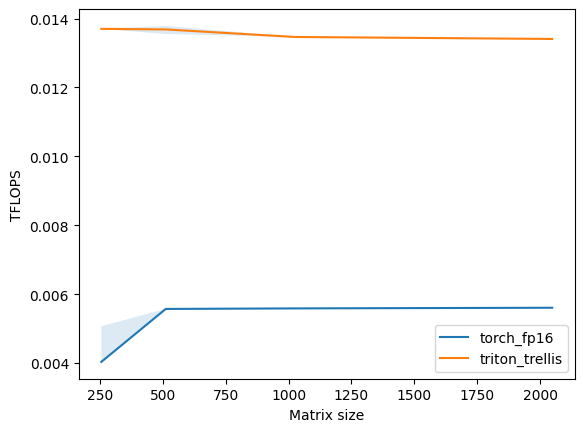

In [5]:
# %%
# Benchmark
# ---------
#
# Square Matrix Performance
# ~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# We can now compare the performance of our kernel against that of cuBLAS or rocBLAS. Here we focus on square matrices,
# but feel free to arrange this script as you wish to benchmark any other matrix shape.

configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
        x_vals=[256, 
                512,
                1024,
                [2048, 1024, 2048], #, 1024, 1536],
        ],
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals=["torch_fp16", "triton_trellis"],  # Label name for the lines
        line_names=["torch_fp16", "triton_trellis"],  # Line styles
        #styles=[("green", "-"), ("blue", "-")],
        ylabel="TFLOPS",  # Label name for the y-axis
        xlabel="Matrix size",
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))


@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    # a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    # b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    y = torch.randn(M, K, dtype=torch.float16, device="cuda")
    x_compressed = torch.randint(0, 255, (K // 16, N * 4, 64), dtype=torch.uint8, device="cuda")
    x_decompressed = decode_trellis_python(x_compressed).to(torch.float16)

    
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y, x_decompressed), quantiles=quantiles)
    if provider == "torch_trellis":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: trellis_matmul_torch(y, x_compressed), quantiles=quantiles)
    if provider == 'triton_trellis':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: trellis_matmul_triton(y, x_compressed), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=False, print_data=True)